## Elastic Net Model

Libraries

In [1]:
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

Loading dataset

In [2]:
housing_prices_df_raw = pd.read_csv('../src/data/train.csv')
test_housing_prices_df_raw = pd.read_csv('../src/data/test.csv')

train_hdf = housing_prices_df_raw.copy()
test_hdf = test_housing_prices_df_raw.copy()

hdf = pd.concat([train_hdf, test_hdf], axis = 0, sort = False)

## Inspect data frame

## Identify features by variable type

ord_feat_num = ['OverallQual', 'OverallCond', 'BsmtFullBath', 
        'BsmtHalfBath', 'FullBath', 'HalfBath',
        'TotRmsAbvGrd', 'Fireplaces', 'BedroomAbvGr', 
        'KitchenAbvGr', 'GarageCars']

ord_feat_cat = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
        'HeatingQC', 'KitchenQual', 'FireplaceQu', 
        'GarageQual', 'GarageCond', 'PoolQC']

ord_feat = ord_feat_num + ord_feat_cat

nom_feat = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 
       'LandContour', 'Utilities', 'Neighborhood', 
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 
       'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 
       'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 
       'HouseStyle','LotConfig', 'Street', 'LandSlope']

cont_feat = ['LotFrontage', 'LotArea', 'YearBuilt', 
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
       'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
       'MiscVal', 'MoSold', 'YrSold','BsmtUnfSF', 'GarageArea', 
       'LowQualFinSF', 'GrLivArea']

FileNotFoundError: [Errno 2] File b'../src/data/train.csv' does not exist: b'../src/data/train.csv'

In [6]:
hdf[ord_feat_cat] = hdf[ord_feat_cat].replace({'Ex': 5, 'Gd': 4, 
                                               'TA': 3, 'Fa': 2, 
                                               'Po': 1, np.nan: 0})

hdf[['BsmtExposure']] = hdf[['BsmtExposure']].replace({'Gd': 4, 'Av': 3, 
                                                       'Mn': 2, 'No': 1, 
                                                       np.nan: 0})

hdf[['BsmtFinType1', 'BsmtFinType2']] = hdf[['BsmtFinType1', 
                                             'BsmtFinType2']].replace({'GLQ': 6, 'ALQ': 5, 
                                                                       'BLQ': 4, 'Rec': 3, 
                                                                       'LwQ': 2, 'Unf': 1, 
                                                                       np.nan: 0})

hdf[['Fence']] = hdf[['Fence']].replace({'MnPrv': 'HasFence', 'GdWo': 'HasFence', 
                                         'GdPrv': 'HasFence', 'MnWw': 'HasFence', 
                                         np.nan: 'NoFence'})


hdf['LotFrontage'] = hdf.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


for col in set(hdf.columns) - {'SalePrice', 'LotFrontage'}:
    if hdf[col].dtype == 'object':
        hdf.fillna({col:stats.mode(hdf[col]).mode[0]}, inplace = True)
    else:
        hdf.fillna({col:np.median(hdf.loc[~hdf[col].isnull(), col])}, inplace = True)


hdf['Remodeled'] = pd.Series([1 if a > 0 else 0 for a in (hdf['YearRemodAdd'] - hdf['YearBuilt'])])
hdf['TotalPorchAreasSF'] = hdf['OpenPorchSF'] + hdf['EnclosedPorch'] + \
                            hdf['3SsnPorch'] + hdf['ScreenPorch'] + hdf['WoodDeckSF']
hdf ['TotalBath'] = hdf['FullBath'] + hdf['BsmtFullBath'] + .5*(hdf['HalfBath'] + hdf['BsmtHalfBath'])
hdf['OtherRoomsAbvGrd'] = hdf['TotRmsAbvGrd'] - hdf['KitchenAbvGr'] - hdf['FullBath']


hdf.drop(columns = ['Utilities', 'Street', 'PoolQC'], inplace = True)
hdf.drop(columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], inplace = True)
hdf.drop(columns = ['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'], inplace = True)
hdf.drop(columns = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'], inplace = True)
hdf.drop(columns = 'MiscFeature', inplace = True)
hdf.drop(columns = 'TotRmsAbvGrd', inplace = True)


ord_feat_num = set(ord_feat_num).union(set(['TotalBath', 'OtherRoomsAbvGrd', 'Remodeled'])) - \
set(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',' KitchenAbvGr', 'GarageCars'])

ord_feat_cat = set(ord_feat_cat) - set(['PoolQC'])

ord_feat = ord_feat_num.union(ord_feat_cat)

nom_feat = set(nom_feat) - set(['Utilities','MiscFeature','Street'])

cont_feat = list(set(cont_feat).union(set(['TotalPorchAreasSF'])) - set(['Utilities', 'Street', 'PoolQC'] +\
['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'] +\
['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'] +\
['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'] +\
['MiscFeature', 'TotRmsAbvGrd']))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


2


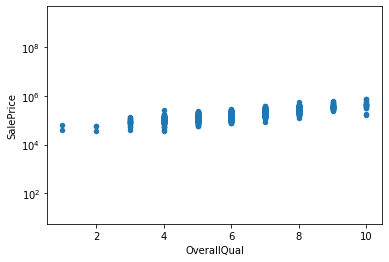

In [7]:
# Dummify and Transforming prine to log price
X = pd.get_dummies(hdf, columns = nom_feat, drop_first=True)

for col in set(X.columns) - {'SalePrice', 'Id'}:
    if np.std(X[col]) != 0:
        X.loc[:, col] = (X[col] - np.mean(X[col]))/np.std(X[col], ddof=1)

X_train = X.loc[~X['SalePrice'].isnull(), :]

X_train.drop((X_train.loc[X_train['GrLivArea']>4.3, :]).index, inplace = True)

X_train.drop((X_train.loc[X_train['LotArea']>10, :]).index, inplace = True)

X_train.drop((X_train.loc[X_train['LotFrontage']>6, :]).index, inplace = True)

X_train.reset_index(drop=True, inplace=True)

print(sum(X_train['OverallQual']< -3))

hdf.plot(x = 'OverallQual', y = 'SalePrice', kind = 'scatter', logy = True)

# X_train = X_train.loc[(X_train['GrLivArea'] < 4000) & (X_train['LotArea'] < 100000) & (X_train['LotFrontage'] < 250),:]

# # #Removing Outliers
# X_train.drop(X_train[(X_train['OverallQual']<5) & (X_train['SalePrice']>200000)].index, inplace=True)

# X_train.drop(X_train[(X_train['GrLivArea']>4500) & (X_train['SalePrice']<300000)].index, inplace=True)

# X_train.reset_index(drop=True, inplace=True)


y_train = np.log1p(X_train.loc[~X_train['SalePrice'].isnull(), 'SalePrice']) ## log price here!!

X_train.drop(columns = ['Id', 'SalePrice'], inplace = True)
X_test = X.loc[X['SalePrice'].isnull(), :].drop(columns = ['SalePrice'])

In [11]:
# # Normalization. Use this one instead of the model option since we have to normalize the test dataset as well.
pd.options.mode.chained_assignment = None
for col in X_train.columns:
    if np.std(X_train[col]) != 0:
        X_train.loc[:, col] = (X_train[col] - np.mean(X_train[col]))/np.std(X_train[col], ddof=1)
    if np.std(X_test[col]) != 0:
        X_test.loc[:, col] = (X_test[col] - np.mean(X_test[col]))/np.std(X_test[col], ddof=1)
        

        


# Final X test and X train

In [32]:
x_test = X_test.drop(columns = 'Id')
x_train = X_train


In [83]:
X_train.to_csv('X_train.csv',index=False)

In [84]:
X_test.to_csv('X_test.csv',index = False)

### From here on is the model, replace the above with an import once file is ready

In [33]:
alphas = [1e-5, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

for a in alphas:
    model = ElasticNet(alpha=a).fit(x_train,y_train)   
    score = model.score(x_train,y_train)
    pred_y = model.predict(x_train)
    mse = mean_squared_error(y_train, pred_y)   
    print("Alpha:{0:.5f}, R2:{1:.3f}, MSE:{2:.3f}, RMSE:{3:.3f}"
       .format(a, score, mse, np.sqrt(mse)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28329926660804183, tolerance: 0.02267332467161165
  positive)


Alpha:0.00001, R2:0.944, MSE:0.009, RMSE:0.094
Alpha:0.00010, R2:0.944, MSE:0.009, RMSE:0.094
Alpha:0.00100, R2:0.942, MSE:0.009, RMSE:0.096
Alpha:0.01000, R2:0.926, MSE:0.012, RMSE:0.107
Alpha:0.10000, R2:0.837, MSE:0.025, RMSE:0.160
Alpha:0.30000, R2:0.584, MSE:0.065, RMSE:0.255
Alpha:0.50000, R2:0.225, MSE:0.121, RMSE:0.348
Alpha:0.70000, R2:0.000, MSE:0.156, RMSE:0.395
Alpha:1.00000, R2:0.000, MSE:0.156, RMSE:0.395


In [39]:
elastic=ElasticNet(alpha=0.001).fit(x_train, y_train)


In [42]:
elastic_cv=ElasticNetCV(alphas=alphas, cv=5)
elastic_mdl = elastic_cv.fit(x_train, y_train)
print(elastic_mdl.alpha_)
print(elastic_mdl.intercept_)

y_pred = elastic_mdl.predict(x_test)



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5265815160154803, tolerance: 0.018329090404178128
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3500645190413687, tolerance: 0.017467509386884517
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10437373302929842, tolerance: 0.018029080290433503
  tol, rng, random, positive)


0.01
12.020148776978003


In [47]:
elastic_cv.mse_path_

array([[0.14933776, 0.1795121 , 0.16017762, 0.14663854, 0.14643197],
       [0.14933776, 0.1795121 , 0.16017762, 0.14663854, 0.14643197],
       [0.11477127, 0.14422776, 0.12520469, 0.11025767, 0.1112188 ],
       [0.06168486, 0.07918688, 0.06979833, 0.05844972, 0.0587114 ],
       [0.02432067, 0.02877119, 0.02814334, 0.0248464 , 0.02372475],
       [0.01171897, 0.0141506 , 0.01494081, 0.01280785, 0.01239556],
       [0.0127709 , 0.01537937, 0.01538305, 0.01232849, 0.01390394],
       [0.01424486, 0.01668973, 0.01698854, 0.01295832, 0.01507925],
       [0.01458307, 0.01698473, 0.01744188, 0.01310881, 0.01524352]])

In [49]:
elastic_cv.score(x_train,y_train)

0.9263529313032638

## Find L1

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
elasticnet_mdl = ElasticNet(warm_start = True, max_iter = 1e7)



Define parameters

In [57]:
alphas = [1e-5, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1_ratios = np.linspace(0.1,1,10)
elastic_params = {'alpha': alphas,'l1_ratio':l1_ratios}

In [59]:
#GridSearch
elastic_param_search = GridSearchCV(estimator = elasticnet_mdl,
                                    param_grid = elastic_params,
                                    cv = 10,
                                    return_train_score = True,
                                    verbose =2)

In [60]:
elastic_param_search.fit(x_train,y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
[CV] alpha=1e-05, l1_ratio=0.1 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.7s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.4s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.3s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   0.7s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.1s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   0.9s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.0s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   0.9s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] .

[CV] ........................ alpha=1e-05, l1_ratio=0.6, total=   0.6s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   1.1s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.7s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.8s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.4s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.7s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.6s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] .

[CV] ....................... alpha=0.0001, l1_ratio=0.2, total=   0.3s
[CV] alpha=0.0001, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.2, total=   0.3s
[CV] alpha=0.0001, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.2, total=   0.3s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] ....... alpha=0.0001, l1_ratio=0.30000000000000004, total=   1.0s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] ....... alpha=0.0001, l1_ratio=0.30000000000000004, total=   1.0s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] ....... alpha=0.0001, l1_ratio=0.30000000000000004, total=   0.9s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] ....... alpha=0.0001, l1_ratio=0.30000000000000004, total=   0.9s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] .

[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   1.1s
[CV] alpha=0.0001, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   1.1s
[CV] alpha=0.0001, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   1.1s
[CV] alpha=0.0001, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   1.1s
[CV] alpha=0.0001, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   0.9s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.9, total=   0.9s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.9, total=   0.8s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................
[CV] .

[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.5 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.5, total=   0.2s
[CV] a

[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.1 ........................................
[CV] .

[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.7000000000000001 .........................
[CV] .......... alpha=0.01, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.7000000000000001 .........................
[CV] .......... alpha=0.01, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.7000000000000001 .........................
[CV] .......... alpha=0.01, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.7000000000000001 .........................
[CV] .

[CV] .......... alpha=0.1, l1_ratio=0.30000000000000004, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.30000000000000004 .........................
[CV] .......... alpha=0.1, l1_ratio=0.30000000000000004, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.30000000000000004 .........................
[CV] .......... alpha=0.1, l1_ratio=0.30000000000000004, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.30000000000000004 .........................
[CV] .......... alpha=0.1, l1_ratio=0.30000000000000004, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.30000000000000004 .........................
[CV] .......... alpha=0.1, l1_ratio=0.30000000000000004, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.30000000000000004 .........................
[CV] .......... alpha=0.1, l1_ratio=0.30000000000000004, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.30000000000000004 .........................
[CV] .......... alpha=0.1, l1_ratio=0.30000000000000004, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.30000000000000004 .........................
[CV] .

[CV] .......................... alpha=0.1, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .

[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.6 .........................................
[CV] .

[CV] .......................... alpha=0.5, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.1 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.1 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.1 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.2 .........................................
[CV] .

[CV] ........... alpha=0.5, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.7000000000000001 ..........................
[CV] ........... alpha=0.5, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.7000000000000001 ..........................
[CV] ........... alpha=0.5, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.7000000000000001 ..........................
[CV] ........... alpha=0.5, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.7000000000000001 ..........................
[CV] ........... alpha=0.5, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .

[CV] .......................... alpha=0.7, l1_ratio=0.4, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.4 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.4, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.4 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.4, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.4 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.4, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.4 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.4, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.4 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.4, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.4 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.4, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.4 .........................................
[CV] .

[CV] .......................... alpha=0.7, l1_ratio=1.0, total=   0.0s
[CV] alpha=0.7, l1_ratio=1.0 .........................................
[CV] .......................... alpha=0.7, l1_ratio=1.0, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] .

[CV] ............. alpha=1, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=1, l1_ratio=0.7000000000000001 ............................
[CV] ............. alpha=1, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=1, l1_ratio=0.7000000000000001 ............................
[CV] ............. alpha=1, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=1, l1_ratio=0.7000000000000001 ............................
[CV] ............. alpha=1, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=1, l1_ratio=0.7000000000000001 ............................
[CV] ............. alpha=1, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.8, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.8, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  3.5min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=10000000.0,
                                  normalize=False, positive=False,
                                  precompute=False, random_state=None,
                                  selection='cyclic', tol=0.0001,
                                  warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5,
                                   0.7, 1],
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=2)

In [61]:
elastic_param_search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.4}

In [64]:
elastic_param_search.cv_results_['mean_test_score'].max()

0.9172800076801535

### Refine search

In [65]:
alphas2 = np.linspace(0.005,0.2,50)
l1_ratios2 = np.linspace(0.3,0.5,20)
elastic_params2 = {'alpha': alphas2,'l1_ratio':l1_ratios2}

In [66]:
elastic_param_search2 = GridSearchCV(estimator = elasticnet_mdl,
                                    param_grid = elastic_params2,
                                    cv = 10,
                                    return_train_score = True,
                                    verbose =2)

In [67]:
elastic_param_search2.fit(x_train,y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
[CV] alpha=0.005, l1_ratio=0.3 .......................................
[CV] ........................ alpha=0.005, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ........................ alpha=0.005, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3 .......................................
[CV] ........................ alpha=0.005, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3 .......................................
[CV] ........................ alpha=0.005, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3 .......................................
[CV] ........................ alpha=0.005, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3 .......................................
[CV] ........................ alpha=0.005, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3 .......................................
[CV] ........................ alpha=0.005, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3 .......................................
[CV] ........................ alpha=0.005, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3 .......................................
[CV] .

[CV] ......... alpha=0.005, l1_ratio=0.3631578947368421, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3631578947368421 ........................
[CV] ......... alpha=0.005, l1_ratio=0.3631578947368421, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3631578947368421 ........................
[CV] ......... alpha=0.005, l1_ratio=0.3631578947368421, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3631578947368421 ........................
[CV] ......... alpha=0.005, l1_ratio=0.3631578947368421, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3631578947368421 ........................
[CV] ......... alpha=0.005, l1_ratio=0.3631578947368421, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3631578947368421 ........................
[CV] ......... alpha=0.005, l1_ratio=0.3631578947368421, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3631578947368421 ........................
[CV] ......... alpha=0.005, l1_ratio=0.3631578947368421, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.3631578947368421 ........................
[CV] .

[CV] ......... alpha=0.005, l1_ratio=0.4263157894736842, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.4263157894736842 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.005, l1_ratio=0.4263157894736842 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.005, l1_ratio=0.4263157894736842 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.005, l1_ratio=0.4263157894736842 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4263157894736842, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.4263157894736842 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4263157894736842, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.4263157894736842 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.005, l1_ratio=0.4263157894736842 ........................
[CV] .

[CV] ......... alpha=0.005, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.005, l1_ratio=0.4789473684210526 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4789473684210526, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.4894736842105263 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.005, l1_ratio=0.4894736842105263 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4894736842105263, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.4894736842105263 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.005, l1_ratio=0.4894736842105263 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4894736842105263, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.4894736842105263 ........................
[CV] ......... alpha=0.005, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.005, l1_ratio=0.4894736842105263 ........................
[CV] .

[CV]  alpha=0.008979591836734694, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.34210526315789475, total=   0.1s
[CV] alpha=0.008979591836734694, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.34210526315789475, total=   0.1s
[CV] alpha=0.008979591836734694, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.008979591836734

[CV]  alpha=0.008979591836734694, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.008979591836734694, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.008979591836734694, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.008979591836734694, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.008979591836734694, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.008979591836734694, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.008979591836734694, l1_ratio=0.4052631578947368, total=   0.1s
[CV] alpha=0.008979591836734694, l

[CV]  alpha=0.008979591836734694, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.45789473684210524 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.45789473684210524 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.008979591836734694, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.008979591836734694, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.008979591836734

[CV]  alpha=0.012959183673469387, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.012959183673469387, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.012959183673469387, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.012959183673469387, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.012959183673469387, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.012959183673469387, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.012959183673469387, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.012959183673469

[CV]  alpha=0.012959183673469387, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.012959183673469387, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.012959183673469387, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.012959183673469387, 

[CV]  alpha=0.012959183673469387, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.4368421052631579 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.4368421052631579 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.4368421052631579 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.4368421052631579 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.012959183673469387, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.012959183673469387, l1

[CV] ......... alpha=0.012959183673469387, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.5 ........................
[CV] ......... alpha=0.012959183673469387, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.5 ........................
[CV] ......... alpha=0.012959183673469387, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.5 ........................
[CV] ......... alpha=0.012959183673469387, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.012959183673469387, l1_ratio=0.5 ........................
[CV] ......... alpha=0.012959183673469387, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3 ........................
[CV] ......... alpha=0.016938775510204084, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3 ........................
[CV] ......... alpha=0.016938775510204084, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3 ........................
[CV] .

[CV]  alpha=0.016938775510204084, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3526315789473684 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3526315789473684 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3526315789473684 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3526315789473684 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3526315789473684 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.3631578947368421 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.3631578947368421, total=   0.1s
[CV] alpha=0.016938775510204084, l1

[CV]  alpha=0.016938775510204084, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4157894736842105 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4157894736842105 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4157894736842105 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4157894736842105 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4157894736842105 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4157894736842105 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.016938775510204084, l1

[CV]  alpha=0.016938775510204084, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.016938775510204084, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.016938775510204084, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4789473684210526 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4789473684210526 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4789473684210526 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.016938775510204084, l1_ratio=0.4789473684210526 .........
[CV]  alpha=0.016938775510204084, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.016938775510204084,

[CV]  alpha=0.020918367346938777, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.33157894736842103 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.020918367346938

[CV]  alpha=0.020918367346938777, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.39473684210526316 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.39473684210526316 ........
[CV]  alpha=0.020918367346938777, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.020918367346938

[CV]  alpha=0.020918367346938777, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.020918367346938777, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.020918367346938777, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.020918367346938777, l1_ratio=0.4473684210526315, total=   0.1s
[CV] alpha=0.020918367346938777, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.020918367346938777, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.020918367346938777, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.020918367346938777, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.020918367346938777, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.020918367346938777, l1

[CV] .......... alpha=0.02489795918367347, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3 .........................
[CV] .......... alpha=0.02489795918367347, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3 .........................
[CV] .......... alpha=0.02489795918367347, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3 .........................
[CV] .......... alpha=0.02489795918367347, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3 .........................
[CV] .......... alpha=0.02489795918367347, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3 .........................
[CV] .......... alpha=0.02489795918367347, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3 .........................
[CV] .......... alpha=0.02489795918367347, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.31052631578947365 .........
[CV]  

[CV]  alpha=0.02489795918367347, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0

[CV]  alpha=0.02489795918367347, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0

[CV]  alpha=0.02489795918367347, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.02489795918367347, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.5 .........................
[CV] .......... alpha=0.02489795918367347, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.5 .........................
[CV] .......... alpha=0.02489795918367347, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.02489795918367347, l1_ratio=0.5 .......

[CV]  alpha=0.028877551020408166, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.34210526315789475 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.028877551020408

[CV]  alpha=0.028877551020408166, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.028877551020408166, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.028877551020408166, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.028877551020408166, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.028877551020408166, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.028877551020408166, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.4052631578947368 .........
[CV]  alpha=0.028877551020408166, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.028877551020408166, l1

[CV]  alpha=0.028877551020408166, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.028877551020408166, l1_ratio=0.46842105263157896 ........
[CV]  alpha=0.028877551020408166, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.028877551020408

[CV]  alpha=0.032857142857142856, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.032857142857142

[CV]  alpha=0.032857142857142856, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.032857142857142856, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.032857142857142

[CV]  alpha=0.032857142857142856, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.032857142857142856, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.032857142857142856, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.032857142857142856, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.032857142857142856, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.032857142857142856, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.032857142857142856, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.032857142857142856, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.032857142857142856, l1

[CV] .......... alpha=0.03683673469387755, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3 .........................
[CV] .......... alpha=0.03683673469387755, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3 .........................
[CV] .......... alpha=0.03683673469387755, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3 .........................
[CV] .......... alpha=0.03683673469387755, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3 .........................
[CV] .......... alpha=0.03683673469387755, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3 .........................
[CV] .......... alpha=0.03683673469387755, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3 .........................
[CV] .......... alpha=0.03683673469387755, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3 .........................
[CV] .

[CV]  alpha=0.03683673469387755, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0

[CV]  alpha=0.03683673469387755, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0

[CV]  alpha=0.03683673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.03683673469387755, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.03683673469387755, l1_ratio=0

[CV]  alpha=0.04081632653061224, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04081632653061224, l1_

[CV]  alpha=0.04081632653061224, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.04081632653061224, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.04081632653061224, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.04081632653061224, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.04081632653061224, l1_rat

[CV]  alpha=0.04081632653061224, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04081632653061224, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04081632653061224, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04081632653061224, l1_

[CV]  alpha=0.044795918367346935, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.044795918367346935, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.044795918367346935, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.044795918367346935, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.044795918367346935, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.044795918367346935, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.31052631578947365 ........
[CV]  alpha=0.044795918367346935, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.044795918367346

[CV]  alpha=0.044795918367346935, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.3631578947368421 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.3631578947368421 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.3631578947368421 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.044795918367346935, l1

[CV]  alpha=0.044795918367346935, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4263157894736842 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4263157894736842 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4263157894736842 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4263157894736842 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4263157894736842 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4263157894736842 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.044795918367346935, l1

[CV] alpha=0.044795918367346935, l1_ratio=0.4894736842105263 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4894736842105263 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4894736842105263 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4894736842105263 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4894736842105263 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4894736842105263 .........
[CV]  alpha=0.044795918367346935, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.044795918367346935, l1_ratio=0.4894736842105263 .........
[CV]  alpha=0.044795918367346935, l1_rati

[CV]  alpha=0.04877551020408163, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.04877551020408163, l1_

[CV]  alpha=0.04877551020408163, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.04877551020408163, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.04877551020408163, l1_r

[CV]  alpha=0.04877551020408163, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04877551020408163, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.04877551020408163, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.04877551020408163, l1_

[CV]  alpha=0.05275510204081633, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.05275510204081633, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.05275510204081633, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.05275510204081633, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.05275510204081633, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.05275510204081633, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.05275510204081633, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.05275510204081633, l1_

[CV]  alpha=0.05275510204081633, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0

[CV]  alpha=0.05275510204081633, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0

[CV]  alpha=0.05275510204081633, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.05275510204081633, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.5 .........................
[CV] .......... alpha=0.05275510204081633, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.5 .........................
[CV] .......... alpha=0.05275510204081633, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.05275510204081633, l1_ratio=0.5 .......

[CV]  alpha=0.05673469387755102, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.05673469387755102, l1_

[CV]  alpha=0.05673469387755102, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.05673469387755102, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.05673469387755102, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.05673469387755102, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.05673469387755102, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.05673469387755102, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.05673469387755102, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0

[CV]  alpha=0.05673469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.05673469387755102, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.05673469387755102, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.05673469387755102, l1_

[CV]  alpha=0.060714285714285714, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.32105263157894737 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.060714285714285

[CV] alpha=0.060714285714285714, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.3736842105263158 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.060714285714285714, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.38421052631578945 ........
[CV]  alpha=0.060714285714285714, l1_r

[CV]  alpha=0.060714285714285714, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.4368421052631579 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.4368421052631579 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.4368421052631579 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.4368421052631579 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.4473684210526315 .........
[CV]  alpha=0.060714285714285714, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.060714285714285714, l1

[CV] ......... alpha=0.060714285714285714, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.5 ........................
[CV] ......... alpha=0.060714285714285714, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.5 ........................
[CV] ......... alpha=0.060714285714285714, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.5 ........................
[CV] ......... alpha=0.060714285714285714, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.5 ........................
[CV] ......... alpha=0.060714285714285714, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.5 ........................
[CV] ......... alpha=0.060714285714285714, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.5 ........................
[CV] ......... alpha=0.060714285714285714, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.060714285714285714, l1_ratio=0.5 ........................
[CV] .

[CV]  alpha=0.0646938775510204, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.3526315

[CV]  alpha=0.0646938775510204, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4052631578947368 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4052631578947368 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4157894

[CV]  alpha=0.0646938775510204, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.0646938775510204, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.0646938775510204, l1_ratio=0.4789473

[CV]  alpha=0.0686734693877551, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.

[CV]  alpha=0.0686734693877551, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.

[CV]  alpha=0.0686734693877551, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.0686734693877551, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.0686734693877551, l1_ratio=0.

[CV]  alpha=0.0726530612244898, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.0726530612244898, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.0726530612244898, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.0726530612244898, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.0726530612244898, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.0726530612244898, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.0726530612244898, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.

[CV]  alpha=0.0726530612244898, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.3736842

[CV]  alpha=0.0726530612244898, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4263157894736842 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4368421

[CV]  alpha=0.0726530612244898, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.0726530612244898, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.0726530612244898, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.0726530612244898, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.0726530612244898, l1_ratio=0.5 .............

[CV]  alpha=0.07663265306122449, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=

[CV]  alpha=0.07663265306122449, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0

[CV]  alpha=0.07663265306122449, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.07663265306122449, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.07663265306122449, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.07663265306122449, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.07663265306122449, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.07663265306122449, l1_rati

[CV]  alpha=0.08061224489795919, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08061224489795919, l1_

[CV]  alpha=0.08061224489795919, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.08061224489795919, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.08061224489795919, l1_

[CV]  alpha=0.08061224489795919, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08061224489795919, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08061224489795919, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08061224489795919, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08061224489795919, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08061224489795919, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08061224489795919, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08061224489795919, l1_ratio=0

[CV] .......... alpha=0.08459183673469388, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3 .........................
[CV] .......... alpha=0.08459183673469388, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3 .........................
[CV] .......... alpha=0.08459183673469388, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3 .........................
[CV] .......... alpha=0.08459183673469388, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3 .........................
[CV] .......... alpha=0.08459183673469388, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3 .........................
[CV] .......... alpha=0.08459183673469388, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3 .........................
[CV] .......... alpha=0.08459183673469388, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3 .........................
[CV] .

[CV]  alpha=0.08459183673469388, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0

[CV]  alpha=0.08459183673469388, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0

[CV]  alpha=0.08459183673469388, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.08459183673469388, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.08459183673469388, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.08459183673469388, l1_ratio

[CV]  alpha=0.08857142857142858, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.08857142857142858, l1_

[CV]  alpha=0.08857142857142858, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.08857142857142858, l1_

[CV]  alpha=0.08857142857142858, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08857142857142858, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08857142857142858, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08857142857142858, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.08857142857142858, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.08857142857142858, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.08857142857142858, l1_ratio

[CV] .......... alpha=0.09255102040816326, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3 .........................
[CV] .......... alpha=0.09255102040816326, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3 .........................
[CV] .......... alpha=0.09255102040816326, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3 .........................
[CV] .......... alpha=0.09255102040816326, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3 .........................
[CV] .......... alpha=0.09255102040816326, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3 .........................
[CV] .......... alpha=0.09255102040816326, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3 .........................
[CV] .......... alpha=0.09255102040816326, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.31052631578947365 .........
[CV]  

[CV]  alpha=0.09255102040816326, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0

[CV]  alpha=0.09255102040816326, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0

[CV]  alpha=0.09255102040816326, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.09255102040816326, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.09255102040816326, l1_ratio=0

[CV]  alpha=0.09653061224489796, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.09653061224489796, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.09653061224489796, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ra

[CV]  alpha=0.09653061224489796, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.09653061224489796, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.09653061224489796, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.09653061224489796, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.09653061224489796, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.09653061224489796, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.09653061224489796, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0

[CV]  alpha=0.09653061224489796, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.09653061224489796, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.09653061224489796, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.09653061224489796, l1_

[CV]  alpha=0.10051020408163266, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.10051020408163266, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.10051020408163266, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.10051020408163266, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.10051020408163266, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.10051020408163266, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.10051020408163266, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.10051020408163266, l1_

[CV] alpha=0.10051020408163266, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.10051020408163266, l1_ratio=0.384

[CV]  alpha=0.10051020408163266, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.10051020408163266, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0

[CV] .......... alpha=0.10051020408163266, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.5 .........................
[CV] .......... alpha=0.10051020408163266, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.5 .........................
[CV] .......... alpha=0.10051020408163266, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.5 .........................
[CV] .......... alpha=0.10051020408163266, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.5 .........................
[CV] .......... alpha=0.10051020408163266, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.5 .........................
[CV] .......... alpha=0.10051020408163266, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.5 .........................
[CV] .......... alpha=0.10051020408163266, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.10051020408163266, l1_ratio=0.5 .........................
[CV] .

[CV]  alpha=0.10448979591836735, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0

[CV]  alpha=0.10448979591836735, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0

[CV]  alpha=0.10448979591836735, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.10448979591836735, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.10448979591836735, l1_ratio=0

[CV]  alpha=0.10846938775510205, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.10846938775510205, l1_

[CV]  alpha=0.10846938775510205, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.10846938775510205, l1_

[CV]  alpha=0.10846938775510205, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.10846938775510205, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.10846938775510205, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.10846938775510205, l1_

[CV]  alpha=0.11244897959183674, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.11244897959183674, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.11244897959183674, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.11244897959183674, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.11244897959183674, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.11244897959183674, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.11244897959183674, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.11244897959183674, l1_

[CV]  alpha=0.11244897959183674, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0

[CV]  alpha=0.11244897959183674, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.11244897959183674, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0

[CV] .......... alpha=0.11244897959183674, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.5 .........................
[CV] .......... alpha=0.11244897959183674, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.5 .........................
[CV] .......... alpha=0.11244897959183674, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.5 .........................
[CV] .......... alpha=0.11244897959183674, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.5 .........................
[CV] .......... alpha=0.11244897959183674, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.5 .........................
[CV] .......... alpha=0.11244897959183674, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.5 .........................
[CV] .......... alpha=0.11244897959183674, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.11244897959183674, l1_ratio=0.5 .........................
[CV] .

[CV]  alpha=0.11642857142857144, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0

[CV] alpha=0.11642857142857144, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.426

[CV]  alpha=0.11642857142857144, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.11642857142857144, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.11642857142857144, l1_ratio=0

[CV]  alpha=0.12040816326530612, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.12040816326530612, l1_

[CV]  alpha=0.12040816326530612, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.12040816326530612, l1_

[CV]  alpha=0.12040816326530612, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.12040816326530612, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.12040816326530612, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.12040816326530612, l1_

[CV]  alpha=0.12438775510204082, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.12438775510204082, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.12438775510204082, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.12438775510204082, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.12438775510204082, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.12438775510204082, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.12438775510204082, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.12438775510204082, l1_

[CV]  alpha=0.12438775510204082, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0

[CV]  alpha=0.12438775510204082, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.12438775510204082, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0

[CV] .......... alpha=0.12438775510204082, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.5 .........................
[CV] .......... alpha=0.12438775510204082, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.5 .........................
[CV] .......... alpha=0.12438775510204082, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.5 .........................
[CV] .......... alpha=0.12438775510204082, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.5 .........................
[CV] .......... alpha=0.12438775510204082, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.5 .........................
[CV] .......... alpha=0.12438775510204082, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.12438775510204082, l1_ratio=0.5 .........................
[CV] .......... alpha=0.12438775510204082, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.3 ..........................
[CV] .

[CV]  alpha=0.1283673469387755, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.3526315

[CV]  alpha=0.1283673469387755, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4157894

[CV]  alpha=0.1283673469387755, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.1283673469387755, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1283673469387755, l1_ratio=0.478947

[CV]  alpha=0.1323469387755102, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.33157894736842103 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.

[CV]  alpha=0.1323469387755102, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.39473684210526316 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.

[CV]  alpha=0.1323469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.45789473684210524 ..........
[CV]  alpha=0.1323469387755102, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.1323469387755102, l1_ratio=0.

[CV]  alpha=0.1363265306122449, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1363265306122449, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1363265306122449, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1363265306122449, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1363265306122449, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1363265306122449, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1363265306122449, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.

[CV]  alpha=0.1363265306122449, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.3736842

[CV]  alpha=0.1363265306122449, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1363265306122449, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.4368421

[CV] ........... alpha=0.1363265306122449, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1363265306122449, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1363265306122449, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1363265306122449, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1363265306122449, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1363265306122449, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1363265306122449, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1363265306122449, l1_ratio=0.5 ..........................
[CV] .

[CV]  alpha=0.1403061224489796, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.3526315789473684 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.3631578947368421 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.3631578

[CV]  alpha=0.1403061224489796, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4157894736842105 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4263157894736842 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4263157894736842 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4263157894736842 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4263157

[CV]  alpha=0.1403061224489796, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4894736842105263 ...........
[CV]  alpha=0.1403061224489796, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.1403061224489796, l1_ratio=0.4894736

[CV]  alpha=0.1442857142857143, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.34210526315789475 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.34210526315789475 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.34210526315789475 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.34210526315789475 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.34210526315789475 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.34210526315789475 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.

[CV]  alpha=0.1442857142857143, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4052631578947368 ...........
[CV]  alpha=0.1442857142857143, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4052631578947368 ...........
[CV]  alpha=0.1442857142857143, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4052631578947368 ...........
[CV]  alpha=0.1442857142857143, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4052631578947368 ...........
[CV]  alpha=0.1442857142857143, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4052631578947368 ...........
[CV]  alpha=0.1442857142857143, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4052631578947368 ...........
[CV]  alpha=0.1442857142857143, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4052631

[CV]  alpha=0.1442857142857143, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.46842105263157896 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.46842105263157896 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.46842105263157896 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.46842105263157896 ..........
[CV]  alpha=0.1442857142857143, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.1442857142857143, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.4789473684210526 ...........
[CV]  alpha=0.1442857142857143, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.1442857142857143, l1_ratio=0.47

[CV]  alpha=0.14826530612244898, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.14826530612244898, l1_

[CV]  alpha=0.14826530612244898, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.14826530612244898, l1_

[CV]  alpha=0.14826530612244898, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.14826530612244898, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.14826530612244898, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.14826530612244898, l1_

[CV]  alpha=0.15224489795918367, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.15224489795918367, l1_

[CV]  alpha=0.15224489795918367, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.15224489795918367, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.15224489795918367, l1_rati

[CV]  alpha=0.15224489795918367, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.15224489795918367, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.15224489795918367, l1_ratio=0

[CV] .......... alpha=0.15622448979591838, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3 .........................
[CV] .......... alpha=0.15622448979591838, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3 .........................
[CV] .......... alpha=0.15622448979591838, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3 .........................
[CV] .......... alpha=0.15622448979591838, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3 .........................
[CV] .......... alpha=0.15622448979591838, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3 .........................
[CV] .......... alpha=0.15622448979591838, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3 .........................
[CV] .......... alpha=0.15622448979591838, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3 .........................
[CV] .

[CV]  alpha=0.15622448979591838, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0

[CV]  alpha=0.15622448979591838, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0

[CV]  alpha=0.15622448979591838, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.15622448979591838, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.15622448979591838, l1_ratio=0

[CV]  alpha=0.16020408163265307, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.16020408163265307, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.16020408163265307, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.16020408163265307, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.16020408163265307, l1_rat

[CV]  alpha=0.16020408163265307, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0

[CV]  alpha=0.16020408163265307, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.16020408163265307, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.16020408163265307, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.16020408163265307, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.16020408163265307, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.16020408163265307, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.16020408163265307, l1_rat

[CV]  alpha=0.16418367346938775, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.16418367346938775, l1_

[CV]  alpha=0.16418367346938775, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.16418367346938775, l1_

[CV]  alpha=0.16418367346938775, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.16418367346938775, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.16418367346938775, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.16418367346938775, l1_

[CV]  alpha=0.16816326530612247, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.16816326530612247, l1_

[CV]  alpha=0.16816326530612247, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.16816326530612247, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.16816326530612247, l1_r

[CV]  alpha=0.16816326530612247, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.16816326530612247, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.16816326530612247, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.16816326530612247, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.16816326530612247, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.16816326530612247, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.16816326530612247, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.16816326530612247, l1_ratio=0

[CV] .......... alpha=0.17214285714285715, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.17214285714285715, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.31052631578947365 .........
[CV]  alpha=0.17214285714285715, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.31052631578947365 ....

[CV]  alpha=0.17214285714285715, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.3736842105263158 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0

[CV]  alpha=0.17214285714285715, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.4368421052631579 ..........
[CV]  alpha=0.17214285714285715, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0

[CV] .......... alpha=0.17214285714285715, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.5 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.5 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.5 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.5 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.17214285714285715, l1_ratio=0.5 .........................
[CV] .......... alpha=0.17214285714285715, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.3 .........................
[CV] .......... alpha=0.17612244897959184, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.3 .........................
[CV] .

[CV]  alpha=0.17612244897959184, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0

[CV]  alpha=0.17612244897959184, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0

[CV]  alpha=0.17612244897959184, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.17612244897959184, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.17612244897959184, l1_ratio=0

[CV]  alpha=0.18010204081632653, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.18010204081632653, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.18010204081632653, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.18010204081632653, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.18010204081632653, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.34210526315789475 .........
[CV]  alpha=0.18010204081632653, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.3526315789473684 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.18010204081632653, l1_r

[CV]  alpha=0.18010204081632653, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4157894736842105 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4157894736842105, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0

[CV]  alpha=0.18010204081632653, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0.4789473684210526 ..........
[CV]  alpha=0.18010204081632653, l1_ratio=0.4789473684210526, total=   0.0s
[CV] alpha=0.18010204081632653, l1_ratio=0

[CV]  alpha=0.18408163265306124, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.33157894736842103 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.33157894736842103, total=   0.0s
[CV] alpha=0.18408163265306124, l1_

[CV]  alpha=0.18408163265306124, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.39473684210526316 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.39473684210526316, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.18408163265306124, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.4052631578947368 ..........
[CV]  alpha=0.18408163265306124, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ra

[CV]  alpha=0.18408163265306124, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.18408163265306124, l1_ratio=0.46842105263157896 .........
[CV]  alpha=0.18408163265306124, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.18408163265306124, l1_

[CV]  alpha=0.18806122448979593, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.32105263157894737 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.32105263157894737, total=   0.0s
[CV] alpha=0.18806122448979593, l1_

[CV]  alpha=0.18806122448979593, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.38421052631578945 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.38421052631578945, total=   0.0s
[CV] alpha=0.18806122448979593, l1_

[CV]  alpha=0.18806122448979593, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.18806122448979593, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.18806122448979593, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.4473684210526315 ..........
[CV]  alpha=0.18806122448979593, l1_ratio=0.4473684210526315, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.18806122448979593, l1_ratio=0.45789473684210524 .........
[CV]  alpha=0.18806122448979593, l1_ratio=0.45789473684210524, total=   0.0s
[CV] alpha=0.18806122448979593, l1_rati

[CV] ........... alpha=0.1920408163265306, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1920408163265306, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1920408163265306, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1920408163265306, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1920408163265306, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1920408163265306, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.31052631578947365 ..........
[CV]  alpha=0.1920408163265306, l1_ratio=0.31052631578947365, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.31052

[CV]  alpha=0.1920408163265306, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.3736842105263158 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.3736842105263158, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.3736842

[CV]  alpha=0.1920408163265306, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.4368421052631579 ...........
[CV]  alpha=0.1920408163265306, l1_ratio=0.4368421052631579, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.4473684

[CV] ........... alpha=0.1920408163265306, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1920408163265306, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1920408163265306, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.1920408163265306, l1_ratio=0.5 ..........................
[CV] ........... alpha=0.1920408163265306, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3 .........................
[CV] .......... alpha=0.19602040816326533, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3 .........................
[CV] .......... alpha=0.19602040816326533, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3 .........................
[CV] .......... alpha=0.19602040816326533, l1_ratio=0.3, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3 .........................
[CV] .

[CV]  alpha=0.19602040816326533, l1_ratio=0.3526315789473684, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.3631578947368421 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.3631578947368421, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0

[CV]  alpha=0.19602040816326533, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4263157894736842 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4263157894736842, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0

[CV]  alpha=0.19602040816326533, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0.4894736842105263 ..........
[CV]  alpha=0.19602040816326533, l1_ratio=0.4894736842105263, total=   0.0s
[CV] alpha=0.19602040816326533, l1_ratio=0

[CV] .......... alpha=0.2, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.34210526315789475 .........................
[CV] .......... alpha=0.2, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.34210526315789475 .........................
[CV] .......... alpha=0.2, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.34210526315789475 .........................
[CV] .......... alpha=0.2, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.34210526315789475 .........................
[CV] .......... alpha=0.2, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.34210526315789475 .........................
[CV] .......... alpha=0.2, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.34210526315789475 .........................
[CV] .......... alpha=0.2, l1_ratio=0.34210526315789475, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.34210526315789475 .........................
[CV] .

[CV] ........... alpha=0.2, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.4052631578947368 ..........................
[CV] ........... alpha=0.2, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.4052631578947368 ..........................
[CV] ........... alpha=0.2, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.4052631578947368 ..........................
[CV] ........... alpha=0.2, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.4052631578947368 ..........................
[CV] ........... alpha=0.2, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.4052631578947368 ..........................
[CV] ........... alpha=0.2, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.4052631578947368 ..........................
[CV] ........... alpha=0.2, l1_ratio=0.4052631578947368, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.4052631578947368 ..........................
[CV] .

[CV] alpha=0.2, l1_ratio=0.46842105263157896 .........................
[CV] .......... alpha=0.2, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.46842105263157896 .........................
[CV] .......... alpha=0.2, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.46842105263157896 .........................
[CV] .......... alpha=0.2, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.46842105263157896 .........................
[CV] .......... alpha=0.2, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.46842105263157896 .........................
[CV] .......... alpha=0.2, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.46842105263157896 .........................
[CV] .......... alpha=0.2, l1_ratio=0.46842105263157896, total=   0.0s
[CV] alpha=0.2, l1_ratio=0.46842105263157896 .........................
[CV] .......... alpha=0.2, l1_ratio=0.46842105263157896, total=   0.0s
[CV] a

[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  4.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=10000000.0,
                                  normalize=False, positive=False,
                                  precompute=False, random_state=None,
                                  selection='cyclic', tol=0.0001,
                                  warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([0.005     , 0.00897959, 0.01295918, 0.01693878, 0....
       0.18408163, 0.18806122, 0.19204082, 0.19602041, 0.2       ]),
                         'l1_ratio': array([0.3       , 0.31052632, 0.32105263, 0.33157895, 0.34210526,
       0.35263158, 0.36315789, 0.37368421, 0.38421053, 0.39473684,
       0.40526316, 0.41578947, 0.42631579, 0.43684211, 0.44736842,
       0.45789474, 0.46842105, 0.47894737, 0.48947368, 0.5       ])},
             pre_dispatch='2*n_job

In [70]:
elastic_param_search2.best_params_

{'alpha': 0.008979591836734694, 'l1_ratio': 0.4157894736842105}

In [71]:
elastic_param_search2.cv_results_['mean_test_score'].max()

0.9173384873475747

Broadening search

In [77]:
alphas3 = np.linspace(1e-4,1,20)
l1_ratios3 = np.linspace(0.001,0.1,100)
elastic_params3 = {'alpha': alphas,'l1_ratio':l1_ratios}

In [78]:
elastic_param_search3 = GridSearchCV(estimator = elasticnet_mdl,
                                    param_grid = elastic_params3,
                                    cv = 10,
                                    return_train_score = True,
                                    verbose =2)

In [79]:
elastic_param_search3.fit(x_train,y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
[CV] alpha=1e-05, l1_ratio=0.1 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.5s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.2s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.0s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   0.7s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.0s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   0.9s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   1.0s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] ........................ alpha=1e-05, l1_ratio=0.1, total=   0.9s
[CV] alpha=1e-05, l1_ratio=0.1 .......................................
[CV] .

[CV] ........................ alpha=1e-05, l1_ratio=0.6, total=   0.6s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   1.1s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.6s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.8s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.4s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.6s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] ......... alpha=1e-05, l1_ratio=0.7000000000000001, total=   0.8s
[CV] alpha=1e-05, l1_ratio=0.7000000000000001 ........................
[CV] .

[CV] ....................... alpha=0.0001, l1_ratio=0.2, total=   0.3s
[CV] alpha=0.0001, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.2, total=   0.3s
[CV] alpha=0.0001, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.2, total=   0.6s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] ....... alpha=0.0001, l1_ratio=0.30000000000000004, total=   1.9s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] ....... alpha=0.0001, l1_ratio=0.30000000000000004, total=   1.4s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] ....... alpha=0.0001, l1_ratio=0.30000000000000004, total=   1.5s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] ....... alpha=0.0001, l1_ratio=0.30000000000000004, total=   1.4s
[CV] alpha=0.0001, l1_ratio=0.30000000000000004 ......................
[CV] .

[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   0.9s
[CV] alpha=0.0001, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   1.0s
[CV] alpha=0.0001, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   0.9s
[CV] alpha=0.0001, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   0.9s
[CV] alpha=0.0001, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.8, total=   0.8s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.9, total=   0.8s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0001, l1_ratio=0.9, total=   0.7s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................
[CV] .

[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.4 .......................................
[CV] ........................ alpha=0.001, l1_ratio=0.4, total=   0.2s
[CV] alpha=0.001, l1_ratio=0.5 .......................................
[CV] .

[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] ........................ alpha=0.001, l1_ratio=1.0, total=   0.1s
[CV] alpha=0.001, l1_ratio=1.0 .......................................
[CV] .

[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV] ......................... alpha=0.01, l1_ratio=0.6, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.7000000000000001 .........................
[CV] .

[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2 .........................................
[CV] .

[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .......................... alpha=0.1, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9 .........................................
[CV] .

[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.3, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.3, l1_ratio=0.5 .........................................
[CV] .

[CV] .......................... alpha=0.5, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.1 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.1 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.1 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.2 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.2, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.2 .........................................
[CV] .

[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .......................... alpha=0.5, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.5, l1_ratio=0.8 .........................................
[CV] .

[CV] alpha=0.7, l1_ratio=0.4 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.4, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.5, total=   0.0s
[CV] alpha=0.7, l1_ratio=0.5 .........................................
[CV] .......................... alpha=0.7, l1_ratio=0.5, total=   0.0s
[CV] a

[CV] .......................... alpha=0.7, l1_ratio=1.0, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.1, total=   0.0s
[CV] alpha=1, l1_ratio=0.1 ...........................................
[CV] .

[CV] ............. alpha=1, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=1, l1_ratio=0.7000000000000001 ............................
[CV] ............. alpha=1, l1_ratio=0.7000000000000001, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.8, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.8, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.8, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.8, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] ............................ alpha=1, l1_ratio=0.8, total=   0.0s
[CV] alpha=1, l1_ratio=0.8 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  3.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=10000000.0,
                                  normalize=False, positive=False,
                                  precompute=False, random_state=None,
                                  selection='cyclic', tol=0.0001,
                                  warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5,
                                   0.7, 1],
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=2)

In [80]:
elastic_param_search3.best_params_

{'alpha': 0.01, 'l1_ratio': 0.4}

In [81]:
elastic_param_search3.cv_results_['mean_test_score'].max()

0.9172800076801535

## Model submission


In [82]:
y_predict = np.expm1(elastic_param_search.predict(X_test.loc[:,X_test.columns != 'Id']))

submission = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': y_predict})

submission.to_csv('submission_elasticnet.csv',index=False)

submission

,Id,SalePrice
0,1461,115261.042011
1,1462,157889.622392
2,1463,177460.281838
3,1464,198652.746426
4,1465,200008.551036
...,...,...
1454,2915,85564.663083
1455,2916,86195.703676
1456,2917,169970.875219
1457,2918,123053.630330
